# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

List of tricks to train GANs: https://github.com/soumith/ganhacks

In [1]:
# Import the necessary modules

import os
from typing import Tuple, List

import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FC-GAN for the Generation of Fake MNIST Data


In [2]:
# Frist load the MNist dataset from pytorch

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

### This is what the MNist data looks like:

torch.Size([128, 1, 28, 28])


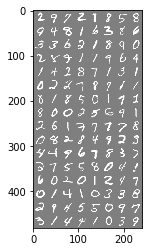

    2     9     7     2


In [3]:
batch_size = 128
lr = 0.0002
train_epoch = 100
trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images)

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### The adverserial Networks:



In [4]:
# first some helper function 

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
    if isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

#### The Generative Network:

Input: x values sampled from uniform distribution

Output: 28 x 28 Image, that should look like the data from MNist 

In [5]:
# The Generative Network

class generativeNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        d = 28
        
        # 100x1 to 224x2x2
        self.deconv0 = nn.ConvTranspose2d(100, 224, 4, 1, 0, bias=False)
        self.deconv0_bn = nn.BatchNorm2d(224)
        # 224x2x2 to 112x7x7
        self.deconv1 = nn.ConvTranspose2d(224, 112, 4, 1, 0, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(112)
        
        # 112x7x7 to 56x14x14
        self.deconv2 = nn.ConvTranspose2d(112, 56, 2, 2, 0, bias=False)
        self.deconv2_bn = nn.BatchNorm2d(56)
        
        # 56x14x14 to 1x28x28
        self.deconv3 = nn.ConvTranspose2d(56, 28, 2, 2, 0, bias=False)
        self.deconv3_bn = nn.BatchNorm2d(28)
        
        self.deconv4 = nn.ConvTranspose2d(28, 1, 1, 1, 0, bias=False)
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(True)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
 
    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = x.unsqueeze(2).unsqueeze(3)
        x = x.reshape((x.shape[0],x.shape[1],1,1))
        x = self.deconv0(x)
        x = self.deconv0_bn(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.deconv1_bn(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.deconv2_bn(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.deconv3_bn(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        return x

#### The discriminative network:

Input: Takes 28x 28 Image as Input
Output: probability of it being real data (non generated)

In [6]:
class discrimNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        # 1x28x28 to 28x14x14
        self.conv1 = nn.Conv2d(1, 28, 2, 2, 0)
        #self.conv1_bn = nn.BatchNorm2d(28)
        
        # 28x14x14 to 56x7x7
        self.conv2 = nn.Conv2d(28, 56, 2, 2, 0)
        self.conv2_bn = nn.BatchNorm2d(56)
        
        # 56x7x7 to 112x4x4
        self.conv3 = nn.Conv2d(56, 112, 4, 1, 0)
        self.conv3_bn = nn.BatchNorm2d(112)
        
        # 112x4x4 to 224x4x4
        self.conv4 = nn.Conv2d(112, 1, (4, 2) , (1, 2), 0)
        #self.conv4_bn = nn.BatchNorm2d(1)
        
        # 2 class fake and real data
        #self.fc_out = nn.Linear(in_features= 2 * 224, out_features=2)
        
        #self.drop = nn.Dropout(p=0.5)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.02)
        
        self.soft = nn.Sigmoid()
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
    
        x = self.conv1(x)
        #x = self.conv1_bn(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        #x = self.conv4_bn(x)
        #x = self.leaky_relu(x)
        #x = x.view(x.shape[0], 2 * 224)
        #x = self.fc_out(x)
        return self.soft(x)

### Simple helper functions


In [7]:
# function for sampling the noise data

def sample_noise(batch_size=batch_size):
    noise_batch = []
    for i in range(batch_size):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, 100)
        #s = np.random.uniform(0,1, 100) # 10 values sample from uniform distribution
        noise_batch.append(s)

    noise_batch = torch.from_numpy(np.asarray(noise_batch)).float() 
    return noise_batch

In [8]:
# function to plot the losses

def plot_losses(loss_g, loss_d, loss_d_fake, k):
    xg = [i for i in range(len(loss_g))]
    xd = [i for i in range(len(loss_d))]
    
    d = []
    sum = 0
    for i in range(len(loss_d)):
        sum += loss_d[i]
        if i % k == k-1:
            d.append(sum / k)
    
    d_fake = []
    sum = 0
    for i in range(len(loss_d_fake)):
        sum += loss_d_fake[i]
        if i % k == k-1:
            d_fake.append(sum / k)
            
    plt.plot( loss_g, label='g')
    plt.plot( d, label='d')
    plt.plot( d_fake, label='d_fake')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.title("Loss of D ang G")

    plt.legend()

    plt.show()

### Train the Networks:

In [9]:
torch.cuda.get_device_capability(device=None)
torch.cuda.get_device_name(device=None)

'GeForce GTX 1050'

In [10]:
# calculate the real labels
a_real = []
a_fake = []
for i in range(batch_size):
    sub1 = [1]
    sub2 = [0]
    for j in range(1):
        sub1.append(0)
        sub2.append(1)
    a_real.append(sub1)
    a_fake.append(sub2)

labels_real = torch.tensor(a_real, dtype=torch.float).cuda()
labels_fake = torch.tensor(a_fake, dtype=torch.float).cuda()

Currently running epoch Nbr 0
tensor([[[[0.5001, 0.5001]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


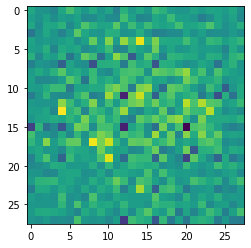

Currently running epoch Nbr 1
tensor([[[[0.5002, 0.5000]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


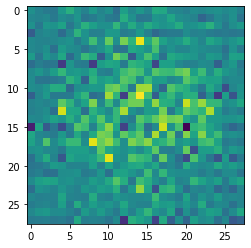

Currently running epoch Nbr 2
tensor([[[[0.5007, 0.4999]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


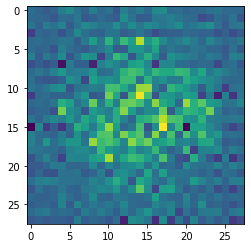

Currently running epoch Nbr 3
tensor([[[[0.5018, 0.4995]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


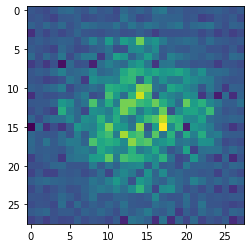

Currently running epoch Nbr 4
tensor([[[[0.5033, 0.4990]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


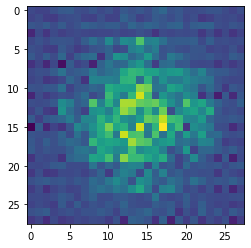

Currently running epoch Nbr 5
tensor([[[[0.5050, 0.4984]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


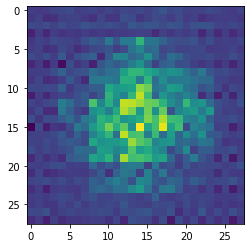

Currently running epoch Nbr 6
tensor([[[[0.5065, 0.4980]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


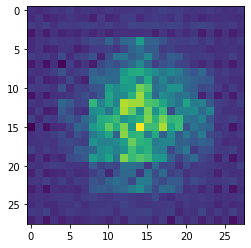

Currently running epoch Nbr 7
tensor([[[[0.5081, 0.4976]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


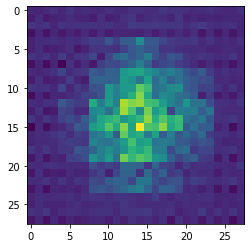

Currently running epoch Nbr 8
tensor([[[[0.5096, 0.4972]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


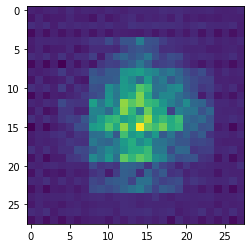

Currently running epoch Nbr 9
tensor([[[[0.5107, 0.4973]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


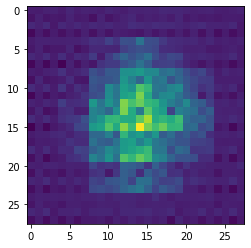

Currently running epoch Nbr 10
tensor([[[[0.5109, 0.4980]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


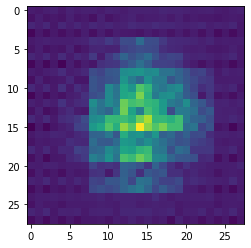

Currently running epoch Nbr 11
tensor([[[[0.5086, 0.5006]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


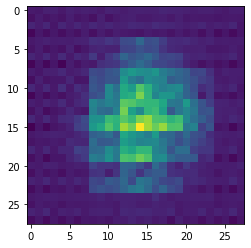

Currently running epoch Nbr 12
tensor([[[[0.5021, 0.5067]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


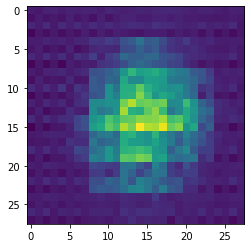

Currently running epoch Nbr 13
tensor([[[[0.4911, 0.5174]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


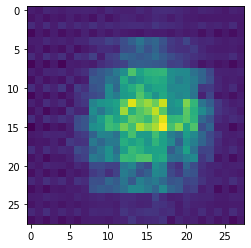

Currently running epoch Nbr 14
tensor([[[[0.4751, 0.5323]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


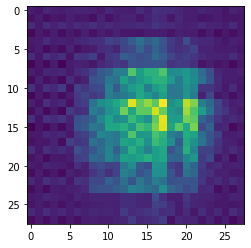

Currently running epoch Nbr 15
tensor([[[[0.4608, 0.5462]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


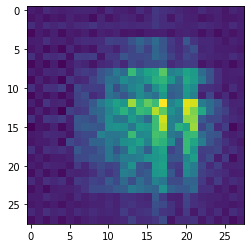

Currently running epoch Nbr 16
tensor([[[[0.4578, 0.5486]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


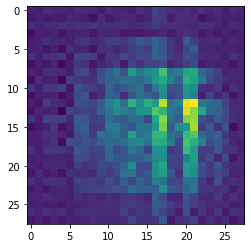

Currently running epoch Nbr 17
tensor([[[[0.4702, 0.5361]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


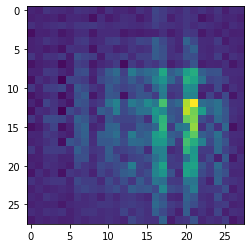

Currently running epoch Nbr 18
tensor([[[[0.4893, 0.5183]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


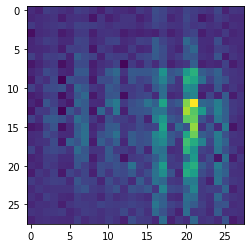

Currently running epoch Nbr 19
tensor([[[[0.5102, 0.4990]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


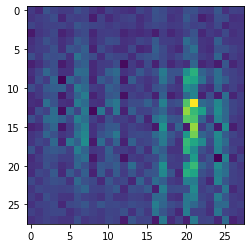

Currently running epoch Nbr 20
tensor([[[[0.5217, 0.4888]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


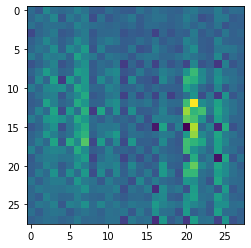

Currently running epoch Nbr 21
tensor([[[[0.5232, 0.4869]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


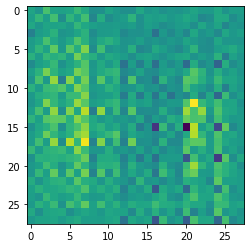

Currently running epoch Nbr 22
tensor([[[[0.5196, 0.4886]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


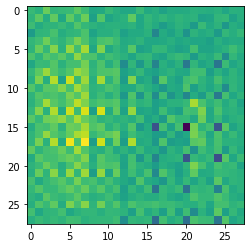

Currently running epoch Nbr 23
tensor([[[[0.5061, 0.4962]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


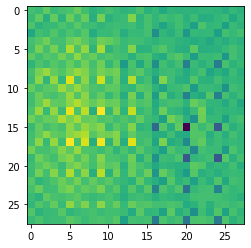

Currently running epoch Nbr 24
tensor([[[[0.5321, 0.4671]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


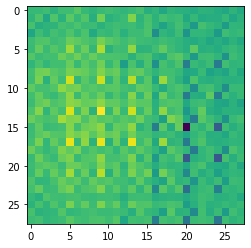

Currently running epoch Nbr 25
tensor([[[[0.5455, 0.4539]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


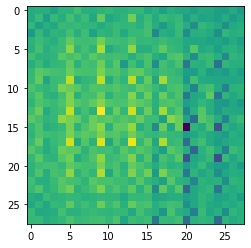

Currently running epoch Nbr 26
tensor([[[[0.5237, 0.4771]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


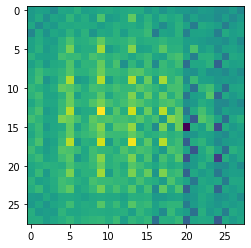

Currently running epoch Nbr 27
tensor([[[[0.4870, 0.5146]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


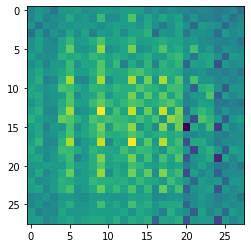

Currently running epoch Nbr 28
tensor([[[[0.4545, 0.5483]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


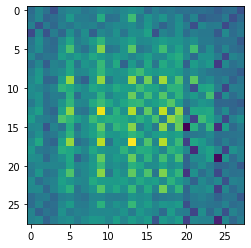

Currently running epoch Nbr 29
tensor([[[[0.4471, 0.5556]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


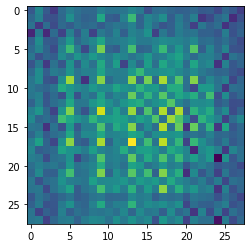

Currently running epoch Nbr 30
tensor([[[[0.4598, 0.5431]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


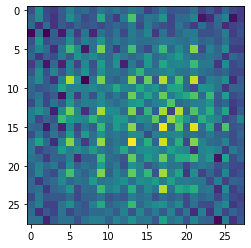

Currently running epoch Nbr 31
tensor([[[[0.4902, 0.5138]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


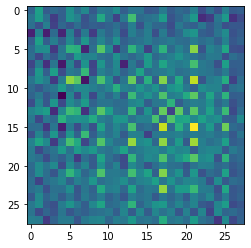

Currently running epoch Nbr 32
tensor([[[[0.5265, 0.4785]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


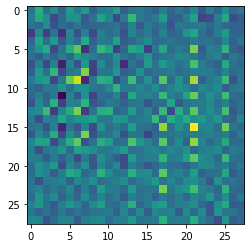

Currently running epoch Nbr 33
tensor([[[[0.5525, 0.4523]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


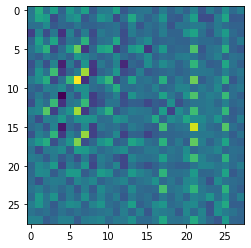

Currently running epoch Nbr 34
tensor([[[[0.5450, 0.4572]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


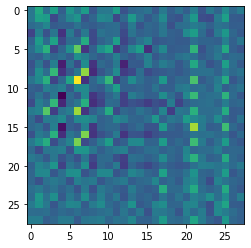

Currently running epoch Nbr 35
tensor([[[[0.5338, 0.4670]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


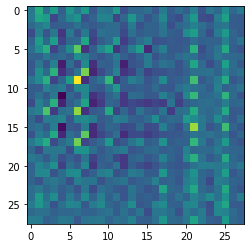

Currently running epoch Nbr 36
tensor([[[[0.5124, 0.4878]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


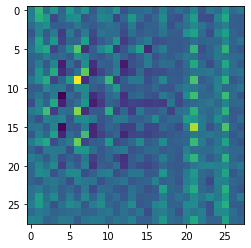

Currently running epoch Nbr 37
tensor([[[[0.4822, 0.5178]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


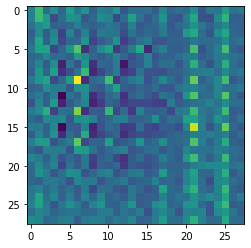

Currently running epoch Nbr 38
tensor([[[[0.4566, 0.5441]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


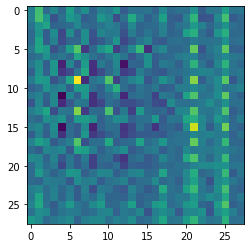

Currently running epoch Nbr 39
tensor([[[[0.4590, 0.5416]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


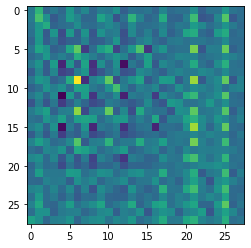

Currently running epoch Nbr 40
tensor([[[[0.4964, 0.5027]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


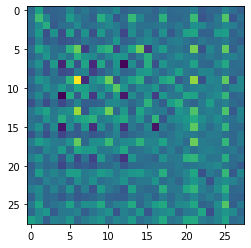

Currently running epoch Nbr 41
tensor([[[[0.5485, 0.4483]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


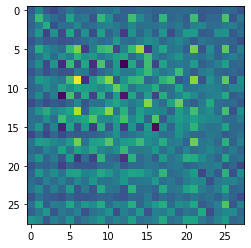

Currently running epoch Nbr 42
tensor([[[[0.5738, 0.4238]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


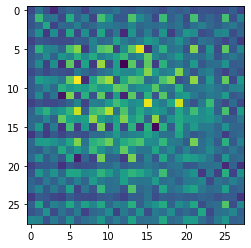

Currently running epoch Nbr 43
tensor([[[[0.5584, 0.4399]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


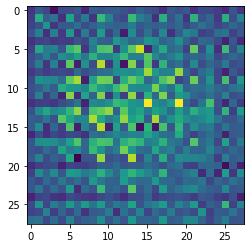

Currently running epoch Nbr 44
tensor([[[[0.5205, 0.4784]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


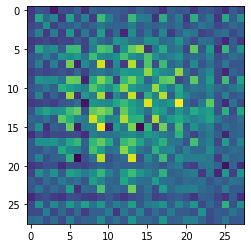

Currently running epoch Nbr 45
tensor([[[[0.4762, 0.5238]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


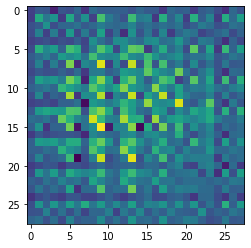

Currently running epoch Nbr 46
tensor([[[[0.4672, 0.5329]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


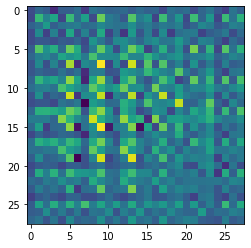

Currently running epoch Nbr 47
tensor([[[[0.4788, 0.5229]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


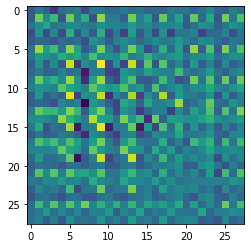

Currently running epoch Nbr 48
tensor([[[[0.4984, 0.5042]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


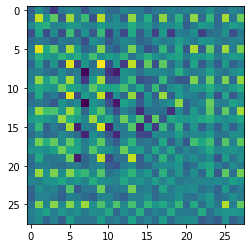

Currently running epoch Nbr 49
tensor([[[[0.5147, 0.4878]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


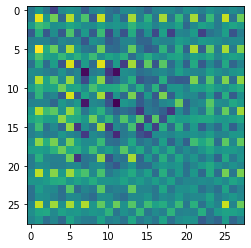

Currently running epoch Nbr 50
tensor([[[[0.5159, 0.4845]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


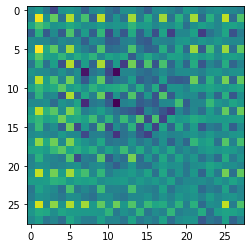

Currently running epoch Nbr 51
tensor([[[[0.5055, 0.4932]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


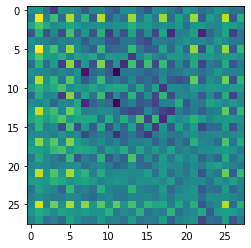

Currently running epoch Nbr 52
tensor([[[[0.4977, 0.5005]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


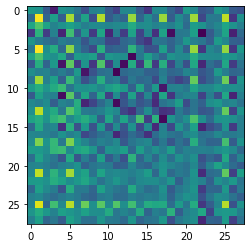

Currently running epoch Nbr 53
tensor([[[[0.5022, 0.4979]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


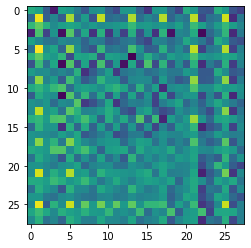

Currently running epoch Nbr 54
tensor([[[[0.5222, 0.4754]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


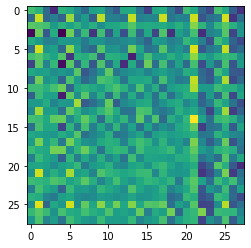

Currently running epoch Nbr 55
tensor([[[[0.5459, 0.4502]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


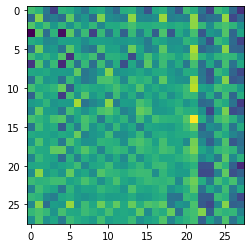

Currently running epoch Nbr 56
tensor([[[[0.5513, 0.4436]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


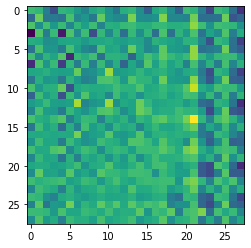

Currently running epoch Nbr 57
tensor([[[[0.5323, 0.4614]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


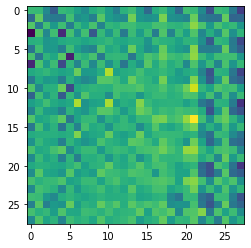

Currently running epoch Nbr 58
tensor([[[[0.5031, 0.4918]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


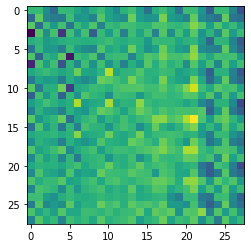

Currently running epoch Nbr 59
tensor([[[[0.4783, 0.5186]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


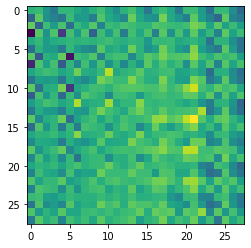

Currently running epoch Nbr 60
tensor([[[[0.4661, 0.5315]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


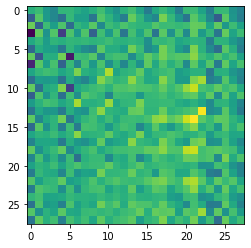

Currently running epoch Nbr 61
tensor([[[[0.4757, 0.5257]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


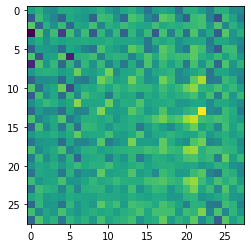

Currently running epoch Nbr 62
tensor([[[[0.5005, 0.5046]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


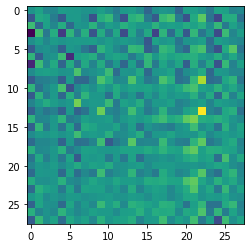

Currently running epoch Nbr 63
tensor([[[[0.5275, 0.4788]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


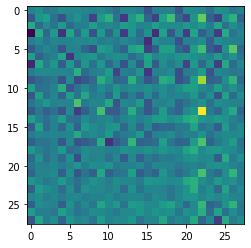

Currently running epoch Nbr 64
tensor([[[[0.5424, 0.4639]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


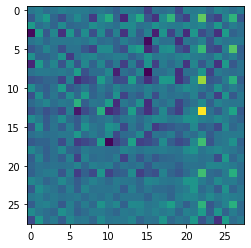

Currently running epoch Nbr 65
tensor([[[[0.5479, 0.4567]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


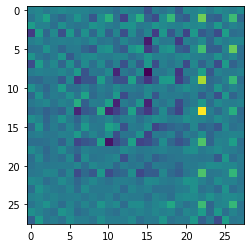

Currently running epoch Nbr 66
tensor([[[[0.5397, 0.4625]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


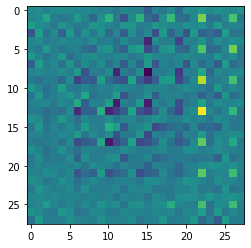

Currently running epoch Nbr 67
tensor([[[[0.5173, 0.4816]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


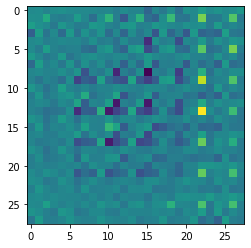

Currently running epoch Nbr 68
tensor([[[[0.4914, 0.5074]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


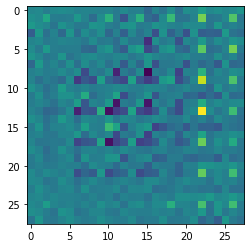

Currently running epoch Nbr 69
tensor([[[[0.4768, 0.5225]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


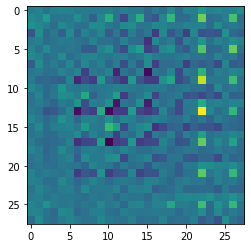

Currently running epoch Nbr 70
tensor([[[[0.4761, 0.5229]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


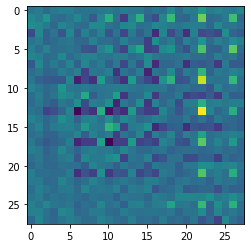

Currently running epoch Nbr 71
tensor([[[[0.4892, 0.5106]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


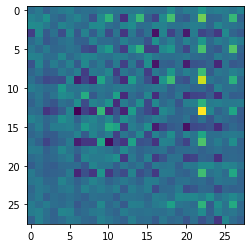

Currently running epoch Nbr 72
tensor([[[[0.5051, 0.4929]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


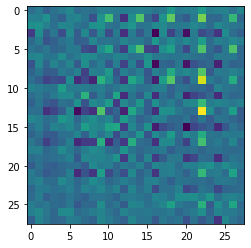

Currently running epoch Nbr 73
tensor([[[[0.5173, 0.4805]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


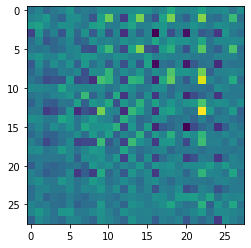

Currently running epoch Nbr 74
tensor([[[[0.5173, 0.4796]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [11]:
G = generativeNet()
D = discrimNet()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.to(device)
D.to(device)

# Define a Loss function and optimizer
optimizer1 = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer2 = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# k = discriminator interations
k = 3

s = sample_noise(1).cuda() 
#print(s)

criterion = nn.BCELoss()

loss_g = []
loss_d = []
loss_d_fake = []
imag = []

mpl.rc('image', cmap='viridis')

# Train the network
for epoch in range(train_epoch):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss1 = 0.0
        running_loss2 = 0.0
        #for i, data in enumerate(trainloader, 0):
        dataiter = iter(trainloader)
        data = dataiter.next()
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer1.zero_grad()
        # sample batch_size * 10 matrix of uniform distributed noise
        noise = sample_noise(batch_size).to(device)
        outputs_fake = D(G(noise).detach()).squeeze(1).squeeze(1)
        outputs_real = D(inputs).squeeze(1).squeeze(1)
        #train d on real images
        loss = criterion(outputs_real, labels_real)
        loss.backward()
        optimizer1.step()
        running_loss1 += loss
        #train d on fake images
        loss = criterion(outputs_fake, labels_fake)
        loss.backward()
        optimizer1.step()
        running_loss2 += loss
        #if i % 63 == 62:   # print every 1000 mini-batches
        #    print('\t[%d, %5d] D loss: %.9f' %
        #          (d + 1, i + 1, running_loss1 / (63*128)))
        loss_d.append(running_loss1)
        loss_d_fake.append(running_loss2)
        running_loss1 = 0.0
        running_loss2 = 0.0

    # 1 training step for G
    #print("\t\t Running %dth iteration on G" % epoch)
    running_loss = 0.0
    #for i in range(126):
    optimizer2.zero_grad()
    noise = sample_noise(batch_size).to(device)
    loss = criterion(D(G(noise)).squeeze(1).squeeze(1), labels_real)
    loss.backward()
    optimizer2.step()
    running_loss += loss
    #if i % 126 == 125:   # print every 1000 mini-batches
    #    print('\t[%d, %5d] G loss: %.9f' %
    #          (d + 1, i + 1, running_loss / (126*128)))
    loss_g.append(running_loss)
    running_loss = 0.0

    a = G(s)
    print(D(a.detach()))
    a = torch.reshape(G(s), (1, 28,28)).cpu()
    npimg = torch.tensor(a.detach().numpy())
    img = torchvision.utils.make_grid(npimg)
    plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
    plt.show()

print('Finished Training')

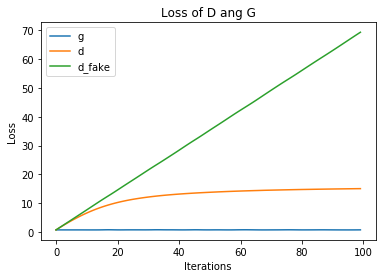

In [308]:
plot_losses(loss_g, loss_d, loss_d_fake, k)

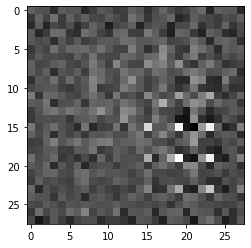

tensor([[[[0.7415, 0.2585]]]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [274]:
mpl.rc('image', cmap='gray')
#imags = torch.tensor(imag[0])
#print(imags.shape)
#torchvision.utils.save_image(imags, "dcgan.png")
#img = torchvision.utils.make_grid(imags)

#npimg = img.numpy()
#plt.imshow(np.transpose(npimg, (1, 2, 0)))
#plt.show(npimg.all()))
#plt.show()


s = sample_noise(1).cuda()
#print(s)
a = G(s)
a = torch.reshape(G(s), (1, 28,28)).cpu()
npimg = torch.tensor(a.detach().numpy())
img = torchvision.utils.make_grid(npimg)
plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
plt.show()

print(D(G(s).detach()))